### Import Datasets

In [0]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
from google.colab import drive
drive.mount('/content/gdrive')
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Training.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

in_dir = "/content/tmp/Training"

In [0]:
train = pd.read_csv('train_files.csv')
data_train_path = [os.path.join(in_dir, f) for f in train['file_name']]

In [0]:
zip_ref_test = zipfile.ZipFile("/content/gdrive/My Drive/Project_C2_Testing-20191129T063942Z-001.zip", 'r')
zip_ref_test.extractall("/content/test")
zip_ref_test.close()

in_test_dir = "/content/test/Project_C2_Testing"
data_test_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(in_test_dir) for f in files]

In [0]:
train_target = train['annotation']

In [0]:
#printing the number of samples in test and trainig sets.
print ("There are %d images in training dataset"%len(data_train_path))
print ("There are %d images in the training set"%len(data_test_paths))
print ("There are %d target count in training dataset"%len(train_target))

There are 896 images in training dataset
There are 129 images in the training set
There are 896 target count in training dataset


### Visualization

In [0]:
train_target

from collections import Counter 
d = Counter(train_target)
x=np.arange(5)
class_count = []
for i in range(0, 5):
  class_count.append(d[i])

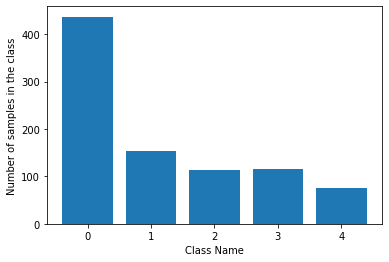

In [0]:
fig, ax = plt.subplots()
plt.bar(x, class_count)
plt.xticks(x, (0, 1, 2, 3, 4))
plt.xlabel("Class Name")
plt.ylabel("Number of samples in the class")
plt.show()

Histogram for color Internsity of the image below:


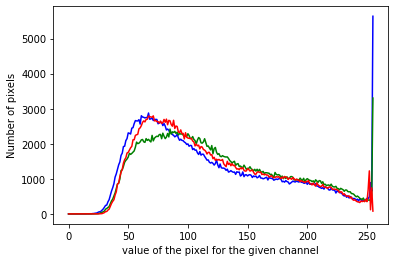

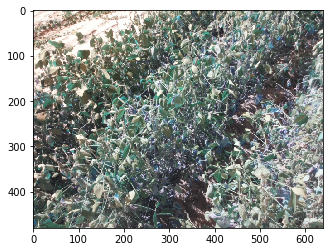

Size of the image - (480 , 640)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


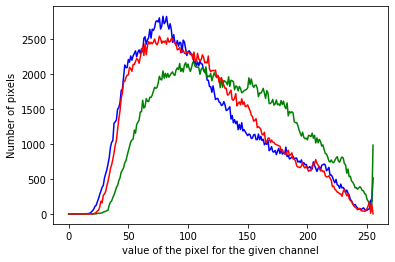

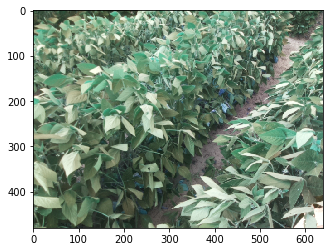

Size of the image - (480 , 640)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


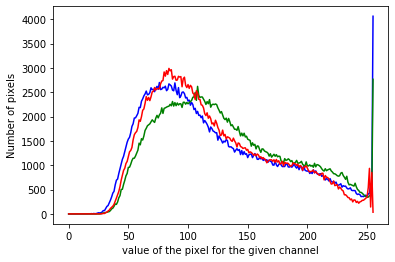

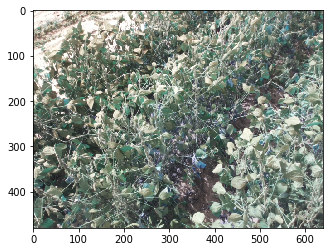

Size of the image - (480 , 640)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


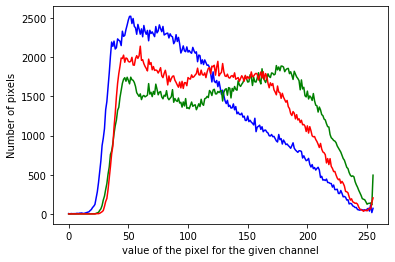

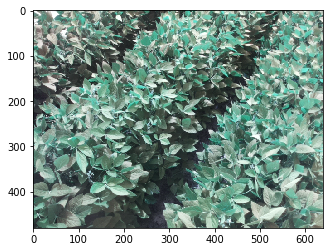

Size of the image - (480 , 640)
----------------------------------------------------------------------------------------------------


In [0]:
def intensity_dist(path):
    #reading the image from its path
    img = cv2.imread(path)
    color = ('b','g','r')
    #calculating the number of pixels of each color
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0,256])
        plt.plot(histr, color=col)
    print("Histogram for color Internsity of the image below:")
    
    #showing the histogram
    plt.xlabel("value of the pixel for the given channel")
    plt.ylabel("Number of pixels")
    plt.show()
    
    #showing the image
    plt.imshow(img)
    plt.show()
    height, width, channels = img.shape
    print("Size of the image - (%d , %d)"%(height,width)) 
    print("-"*100)
    
intensity_dist(data_train_path[56])
intensity_dist(data_train_path[400])
intensity_dist(data_train_path[796])
intensity_dist(data_train_path[812])

### Data Pre-processing

In [0]:
from keras.preprocessing import image
from tqdm import tqdm

#converting image to tensor
def path_to_tensor(img_path):
    # loads RGB image
    img = image.load_img(img_path, target_size=(80,80))
    #convering the image to 3-D tensor with shape (224,224,3)
    x = image.img_to_array(img)
    #convert 3D tensor to 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_tensors = paths_to_tensor(data_train_path).astype('float32')/255
test_tensors = paths_to_tensor(data_test_paths).astype('float32')/255

print(np.shape(train_tensors))
print(np.shape(test_tensors))

100%|██████████| 129/129 [00:01<00:00, 100.67it/s]

(896, 80, 80, 3)
(129, 80, 80, 3)


#### Generic Plot function

In [0]:
import sys, time

def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

### VGG Model

In [0]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Input
import numpy as np

#Extracting the weights of VGG19 model pretrained on Imagenet
#defing the Input shape
input_tensor = Input(shape=(80, 80, 3))
#extracting the weights wof VGG19, without top layers
#and MaxPooling as pooling layer
base_model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=max)
#removing the last layer
output = base_model.get_layer(index = -1).output
#defining the model
VGG19_model2 = Model(base_model.input, output)
VGG19_model2.summary()











Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128) 

In [0]:
VGG19_features = [VGG19_model2.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in train_tensors]

VGG19_features_test = [VGG19_model2.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in test_tensors]

print ("Shape of VGG_19_features: {0}".format(np.shape(VGG19_features)))
print ("Shape of VGG_19_features_test: {0}".format(np.shape(VGG19_features_test)))

Shape of VGG_19_features: (896, 1, 2, 2, 512)
Shape of VGG_19_features_test: (129, 1, 2, 2, 512)


In [0]:
#VGG_19_features having 5 dimensions, so we have to squeeze it to a 4 dim array by removing extra dimension
squeezed_VGG19_train = np.squeeze(VGG19_features, axis=1)
#squeezing the test features
squeezed_VGG19_test = np.squeeze(VGG19_features_test, axis=1)

print ("Shape of squeezed_VGG19_train: {0}".format(np.shape(squeezed_VGG19_train)))
print ("Shape of squeezed_VGG_19_test: {0}".format(np.shape(squeezed_VGG19_test)))

Shape of squeezed_VGG19_train: (896, 2, 2, 512)
Shape of squeezed_VGG_19_test: (129, 2, 2, 512)


In [0]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Dense

leaf_model_vgg = Sequential()
#adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
leaf_model_vgg.add(GlobalMaxPooling2D(input_shape=squeezed_VGG19_train.shape[1:]))
#adding a fully connected dense layer with relu activation function
leaf_model_vgg.add(Dense(1024, activation='relu'))
#adding a dense layer with softmax activation function.
#no of nodes are same as the number of classes of fish.
leaf_model_vgg.add(Dense(5, activation = 'softmax'))
leaf_model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 530,437
Trainable params: 530,437
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
train_targets = to_categorical(train_target)

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
leaf_model_vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#checkpointer for saving only best weights
checkpointer_VGG = ModelCheckpoint(filepath='leaf_model_vgg_point.hdf5', verbose=1, save_best_only=True)

early = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=0, verbose=1)

callbacks_list = [checkpointer_VGG, early] #early

optimized_model_VGG = leaf_model_vgg.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,batch_size=10, epochs=50,callbacks=callbacks_list,verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 627 samples, validate on 269 samples
Epoch 1/50
627/627 [==============================] - 1s 826us/step - loss: 1.3670 - acc: 0.4864 - val_loss: 1.0405 - val_acc: 0.5688

Epoch 00001: val_loss improved from inf to 1.04047, saving model to leaf_model_vgg_point.hdf5
Epoch 2/50
627/627 [==============================] - 0s 598us/step - loss: 1.0199 - acc: 0.5949 - val_loss: 0.8796 - val_acc: 0.6803

Epoch 00002: val_loss improved from 1.04047 to 0.87956, saving model to leaf_model_vgg_point.hdf5
Epoch 3/50
627/627 [==============================] - 0s 547us/step - loss: 0.9089 - acc: 0.6380 - val_loss: 1.0749 - val_acc: 0.5725

Epoch 00003: val_loss did not improve from 0.87956
Epoch 00003: early stopping


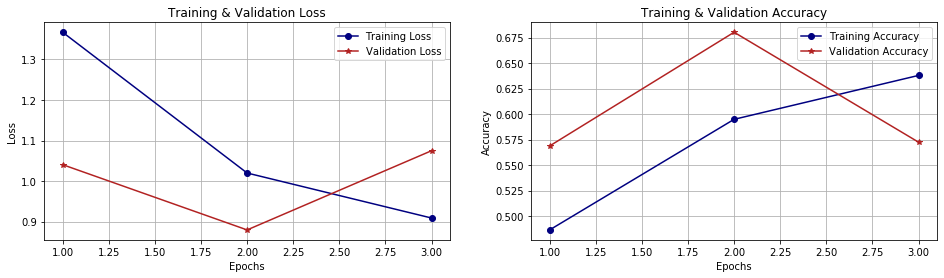

In [0]:
show_plots(optimized_model_VGG.history)

### InceptionV3

In [0]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
ROWS = 80
COLS = 80
input_shape = (ROWS, COLS, 3)

base_model = applications.InceptionV3(weights='imagenet', include_top=False,  
                                      input_shape=(ROWS, COLS,3))

In [0]:
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(5, activation='softmax'))

inception_model = add_model
inception_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
inception_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
inception_features = [inception_model.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in train_tensors]

inception_features_test = [inception_model.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in test_tensors]

print ("Shape of inception_features: {0}".format(np.shape(inception_features)))
print ("Shape of inception_features_test: {0}".format(np.shape(inception_features_test)))

Shape of inception_features: (896, 1, 5)
Shape of inception_features_test: (129, 1, 5)


In [0]:
squeezed_inception_train = np.squeeze(inception_features, axis=1)
squeezed_inception_train = np.squeeze(inception_features_test, axis=1)

print ("Shape of squeezed_inception_train: {0}".format(np.shape(squeezed_inception_train)))
print ("Shape of squeezed_inception_train: {0}".format(np.shape(squeezed_inception_train)))

Shape of squeezed_inception_train: (129, 5)
Shape of squeezed_inception_train: (129, 5)


In [0]:
file_path="inception_weights.best.hdf5"
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=1)

callbacks_list = [checkpoint, early] #early

optimized_model_inception = leaf_model_vgg.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,batch_size=10, epochs=50,callbacks=callbacks_list,verbose=1)

Train on 627 samples, validate on 269 samples
Epoch 1/50
627/627 [==============================] - 2s 4ms/step - loss: 0.8380 - acc: 0.6427 - val_loss: 1.1077 - val_acc: 0.5539

Epoch 00001: val_loss improved from inf to 1.10773, saving model to inception_weights.best.hdf5
Epoch 2/50
627/627 [==============================] - 0s 681us/step - loss: 0.7840 - acc: 0.7097 - val_loss: 0.9423 - val_acc: 0.6283

Epoch 00002: val_loss improved from 1.10773 to 0.94227, saving model to inception_weights.best.hdf5
Epoch 3/50
627/627 [==============================] - 0s 674us/step - loss: 0.7187 - acc: 0.7081 - val_loss: 0.8741 - val_acc: 0.6729

Epoch 00003: val_loss improved from 0.94227 to 0.87407, saving model to inception_weights.best.hdf5
Epoch 4/50
627/627 [==============================] - 0s 635us/step - loss: 0.6940 - acc: 0.7512 - val_loss: 0.6908 - val_acc: 0.7361

Epoch 00004: val_loss improved from 0.87407 to 0.69081, saving model to inception_weights.best.hdf5
Epoch 5/50
627/627 [

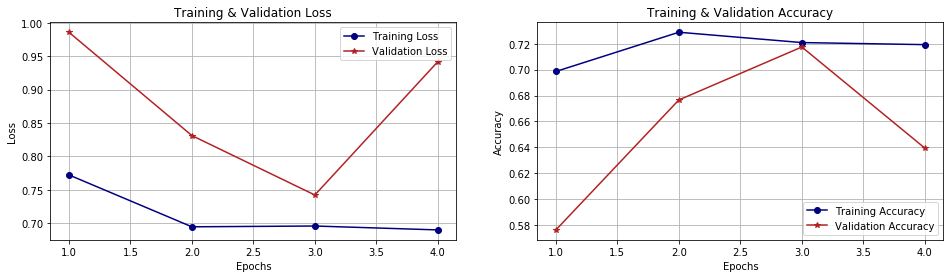

In [0]:
show_plots(optimized_model_inception.history)

### VGG - Feature extraction


In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/3-106-20191126T001229Z-001.zip", 'r')
zip_ref.extractall("/content/trainunlabel")
zip_ref.close()

In [0]:
in_unlabel_dir = "/content/trainunlabel/3-106"
data_unlabelled_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(in_dir) for f in files]

Histogram for color Internsity of the image below:


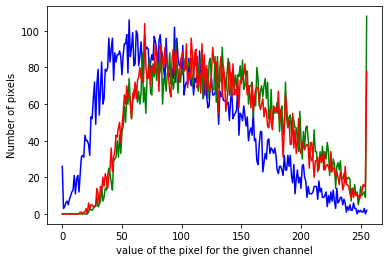

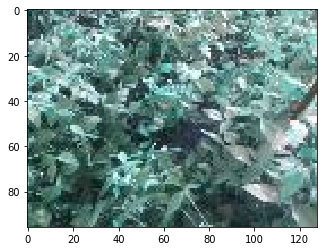

Size of the image - (96 , 128)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


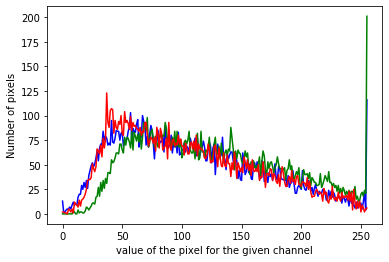

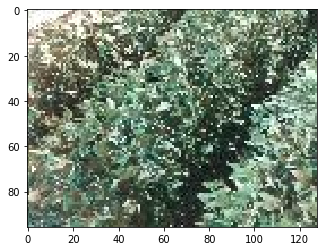

Size of the image - (96 , 128)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


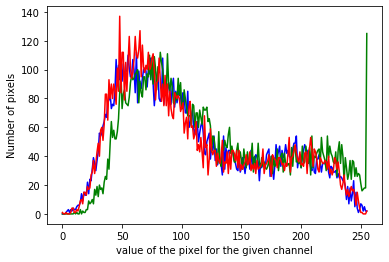

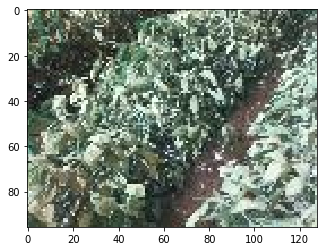

Size of the image - (96 , 128)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


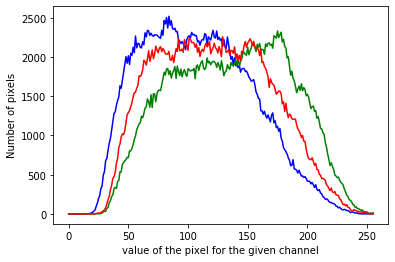

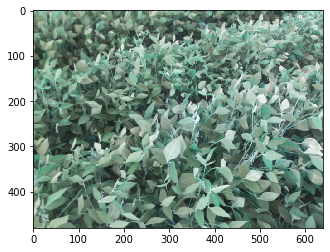

Size of the image - (480 , 640)
----------------------------------------------------------------------------------------------------


In [0]:
intensity_dist(data_unlabelled_paths[56])
intensity_dist(data_unlabelled_paths[400])
intensity_dist(data_unlabelled_paths[796])
intensity_dist(data_unlabelled_paths[812])

In [0]:
image_unlabbeled_data = []
import skimage
def verify_image(img_file):
    try:
        img = skimage.img_as_float(skimage.io.imread(img_file)).astype(np.float32)
        image_unlabbeled_data.append(img)
    except:
      pass

In [0]:
for i in data_unlabelled_paths:
  verify_image(i)

In [0]:
len(image_unlabbeled_data)

2688

In [0]:
from keras.preprocessing import image
from tqdm import tqdm

#converting image to tensor
def path_to_tensor(img_path):
    # loads RGB image
    img = image.load_img(img_path, target_size=(80,80))
    #convering the image to 3-D tensor with shape (224,224,3)
    x = image.img_to_array(img)
    #convert 3D tensor to 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_unlabelled_tensors = paths_to_tensor(data_unlabelled_paths).astype('float32')/255
# test_unlabelled_tensors = paths_to_tensor(data_unlabelled_paths).astype('float32')/255

print(np.shape(train_unlabelled_tensors))
# print(np.shape(test_unlabelled_tensors))

100%|██████████| 2688/2688 [00:10<00:00, 268.55it/s]


(2688, 80, 80, 3)
(2688, 80, 80, 3)


In [0]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Input
import numpy as np

#Extracting the weights of VGG19 model pretrained on Imagenet
#defing the Input shape
input_tensor = Input(shape=(80, 80, 3))
#extracting the weights wof VGG19, without top layers
#and MaxPooling as pooling layer
base_model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=max)
#removing the last layer
output = base_model.get_layer(index = -1).output
#defining the model
VGG19_model3 = Model(base_model.input, output)
VGG19_model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [0]:
VGG19_ufeatures = [VGG19_model2.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in train_unlabelled_tensors]

# VGG19_ufeatures_test = [VGG19_model2.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in train_unlabelled_tensors]

print ("Shape of VGG_19_features: {0}".format(np.shape(VGG19_ufeatures)))
# print ("Shape of VGG_19_features_test: {0}".format(np.shape(VGG19_ufeatures_test)))

Shape of VGG_19_features: (2688, 1, 2, 2, 512)


In [0]:
#VGG_19_features having 5 dimensions, so we have to squeeze it to a 4 dim array by removing extra dimension
squeezed_uVGG19_train = np.squeeze(VGG19_ufeatures, axis=1)

print ("Shape of squeezed_VGG19_train: {0}".format(np.shape(squeezed_uVGG19_train)))

Shape of squeezed_VGG19_train: (2688, 2, 2, 512)


In [0]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Dense

leaf_model_vgg_2 = Sequential()
#adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
leaf_model_vgg_2.add(GlobalMaxPooling2D(input_shape=squeezed_uVGG19_train.shape[1:]))
#adding a fully connected dense layer with relu activation function
leaf_model_vgg_2.add(Dense(1024, activation='relu'))
#adding a dense layer with softmax activation function.
#no of nodes are same as the number of classes of fish.
leaf_model_vgg_2.add(Dense(5, activation = 'softmax'))
leaf_model_vgg_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 5125      
Total params: 530,437
Trainable params: 530,437
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
leaf_model_vgg_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#checkpointer for saving only best weights
checkpointer_uVGG = ModelCheckpoint(filepath='leaf_model_uvgg_point.hdf5', verbose=1, save_best_only=True)

early = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=0, verbose=1)

callbacks_list = [checkpointer_uVGG] #early

optimized_model_uVGG = leaf_model_vgg_2.fit(squeezed_uVGG19_train[:896],train_targets,validation_split=0.3,batch_size=10, epochs=50,callbacks=callbacks_list,verbose=1)

Train on 627 samples, validate on 269 samples
Epoch 1/50
627/627 [==============================] - 4s 6ms/step - loss: 1.4123 - acc: 0.4848 - val_loss: 1.5188 - val_acc: 0.4758

Epoch 00001: val_loss improved from inf to 1.51883, saving model to leaf_model_uvgg_point.hdf5
Epoch 2/50
627/627 [==============================] - 0s 670us/step - loss: 1.3913 - acc: 0.4928 - val_loss: 1.4245 - val_acc: 0.4758

Epoch 00002: val_loss improved from 1.51883 to 1.42452, saving model to leaf_model_uvgg_point.hdf5
Epoch 3/50
627/627 [==============================] - 0s 644us/step - loss: 1.3652 - acc: 0.4833 - val_loss: 1.4319 - val_acc: 0.4758

Epoch 00003: val_loss did not improve from 1.42452
Epoch 4/50
627/627 [==============================] - 0s 676us/step - loss: 1.3492 - acc: 0.4992 - val_loss: 1.4882 - val_acc: 0.4572

Epoch 00004: val_loss did not improve from 1.42452
Epoch 5/50
627/627 [==============================] - 0s 625us/step - loss: 1.3414 - acc: 0.4928 - val_loss: 1.4749 - va

### pre-trained vgg-16

In [0]:
from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
train_dir = in_unlabel_dir

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
 
train_features = np.zeros(shape=(2688, 7, 7, 512))
train_labels = np.zeros(shape=(2688,5))
 
train_generator = datagen.flow_from_directory(
    in_unlabel_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 0 images belonging to 0 classes.


In [0]:
len(squeezed_uVGG19_train)

2688